In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from src.dataset import OzeDataset, OzeEvaluationDataset
from src.model import BenchmarkLSTM

# Parameters

In [2]:
BATCH_SIZE = 4
NUM_WORKERS = 4
LR = 1e-2
EPOCHS = 5
HIDDEN_DIM = 100
K = 672

# Train the benchmark

### Load the dataset

In [3]:
dataloader = DataLoader(OzeDataset(dataset_x_path="sample_dataset/x_train.csv", dataset_y_path="sample_dataset/y_train.csv", labels_path="labels.json"),
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        num_workers=NUM_WORKERS)

m, M = dataloader.dataset.m, dataloader.dataset.M
# Normalization constants, we will need them in the prediction part

### Load the network

In [4]:
# Load benchmark network with Adam optimizer and MSE loss function
net = BenchmarkLSTM(hidden_dim=HIDDEN_DIM)
optimizer = optim.Adam(net.parameters(), lr=LR)
loss_function = nn.MSELoss()

### Train the network

In [5]:
# Prepare loss history
hist_loss = np.zeros(EPOCHS)
for idx_epoch in range(EPOCHS):
    running_loss = 0
    with tqdm(total=len(dataloader.dataset), desc=f"[Epoch {idx_epoch+1:3d}/{EPOCHS}]") as pbar:
        for idx_batch, (x, y) in enumerate(dataloader):
            optimizer.zero_grad()

            # Propagate input
            output = net(x)

            # Comupte loss
            loss = loss_function(output, y)

            # Backpropage loss
            loss.backward()

            # Update weights
            optimizer.step()

            running_loss += loss.item()
            pbar.set_postfix({'loss': running_loss/(idx_batch+1)})
            pbar.update(BATCH_SIZE)
        
    hist_loss[idx_epoch] = running_loss/len(dataloader)
plt.plot(hist_loss, 'o-')
print(f"Loss: {float(hist_loss[-1]):5f}")

[Epoch   2/5]:   5%|▍         | 24/500 [00:00<00:18, 25.25it/s, loss=0.0195]


KeyboardInterrupt: 

### Plot the results for a training example

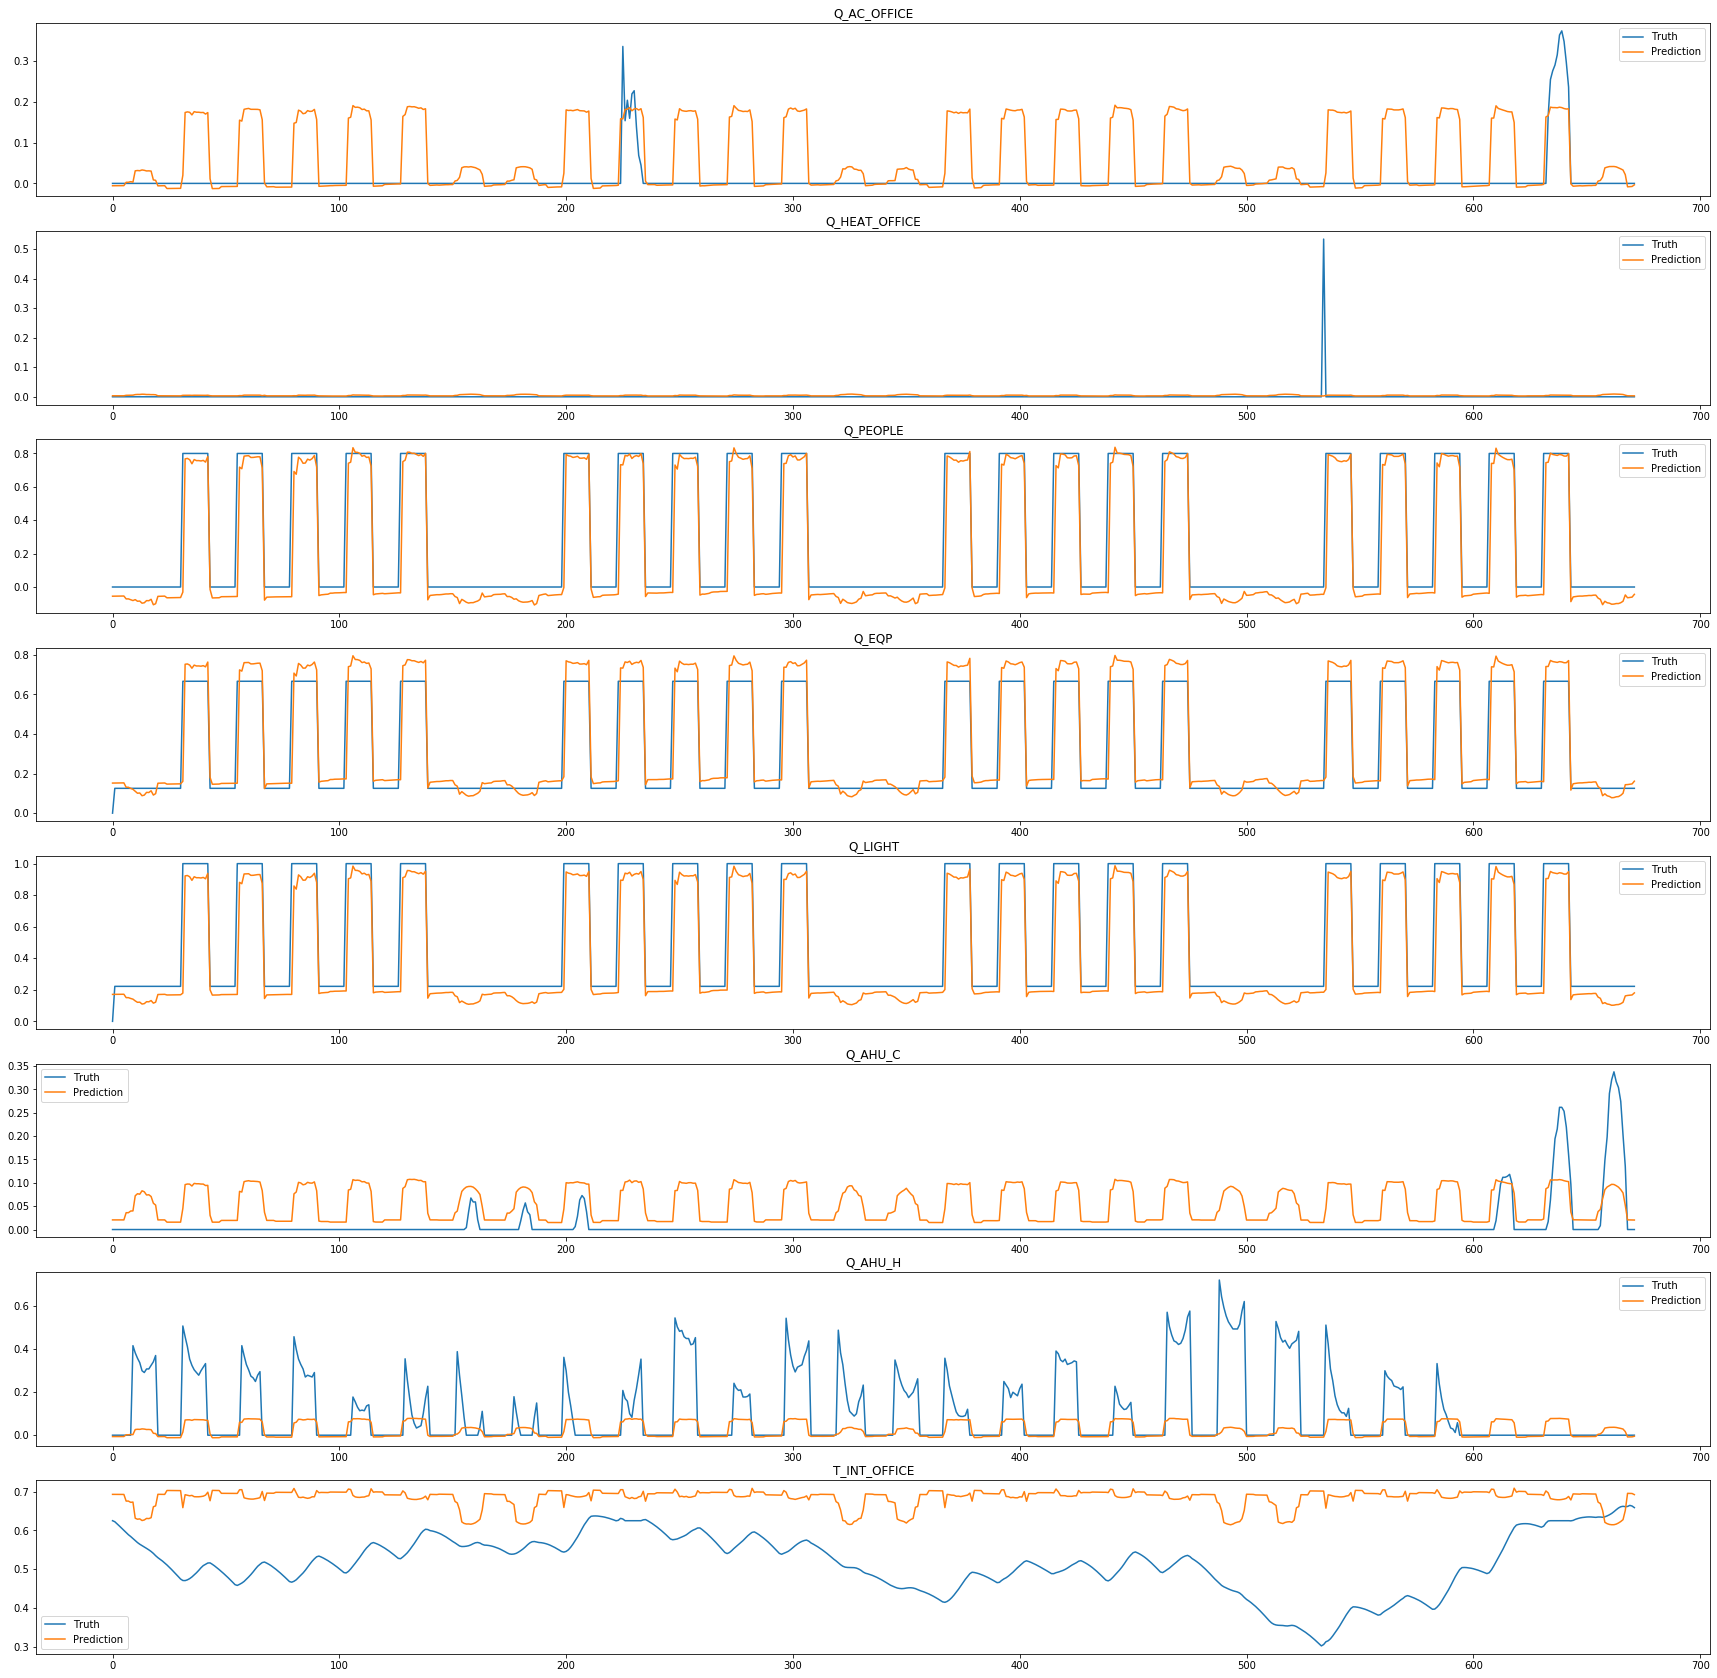

In [6]:
# Select training example
idx = np.random.randint(0, len(dataloader.dataset))
x, y = dataloader.dataset[idx]

# Run predictions
with torch.no_grad():
    x = torch.Tensor(x[np.newaxis, :, :])
    netout = net(x)

plt.figure(figsize=(30, 30))
for idx_output_var in range(8):
    # Select real temperature
    y_true = y[:, idx_output_var]

    y_pred = netout[0, :, idx_output_var]
    y_pred = y_pred.numpy()

    plt.subplot(8, 1, idx_output_var+1)
    
    plt.plot(y_true, label="Truth")
    plt.plot(y_pred, label="Prediction")
    plt.title(dataloader.dataset.labels["X"][idx_output_var])
    plt.legend()
plt.savefig("fig")

# Evaluation

### Load evaluation dataset

dataset_eval = OzeEvaluationDataset(dataset_x_path="x_test.csv", labels_path="labels.json")
m_test = len(dataset_eval)

### Run prediction

predictions = np.zeros((m_test, K, 8))
with torch.no_grad():
    for idx, line in tqdm(enumerate(dataset_eval), total=m_test):
        # Run prediction
        netout = net(torch.Tensor(line[np.newaxis, :, :])).numpy()
        
        # De-normalize output
        predictions[idx] = netout

# Normlization backward
predictions = predictions * (M - m +np.finfo(float).eps) + m

### Export as csv

lines_output = predictions.transpose((0, 2, 1)).reshape((m_test, -1))
csv_header = [f"{var_name}_{k}" for var_name in dataset_eval.labels['X'] for k in range(K)]

pd.DataFrame(lines_output, columns=csv_header, index=range(7500, 8000)).to_csv(f"y_bench.csv")